# Project 3: Web APIs & NLP

## Problem Statement

Being part of an in-house Data Science Marketing Team of a beverage company venturing into e-commerce, my team and I are planning to leverage on Machine Learning to refine our recommendations to our e-customers, based on keywords.

The main objective of this project is to scrape two subreddits: `/r coffee` and `/r tea` through a webscrapper, leveraging on Reddit's API. The scraped data from the two subreddits will then be passed through various classification models, CountVectorizer/TfidVectorizer with Naive Bayes Classifier, LogisticRegression that will assign each observation to the most likely class of subreddit. The models should help the data science marketing team of my company identify what keywords are likely to predict the correct subreddit, and in turn, tailor a more enriching experience to our customers.

In this process, the subreddit posts will undergo preprocessing and EDA. The success of the models that we decide on will be determined through the highest accuracy based on the scores obtained.

## Data Collection

### Importing Libraries

In [1]:
#import essential libraries
import pandas as pd
import regex as re
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import Counter
from wordcloud import WordCloud

#import NLTK libraries
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#import beautifulsoup
from bs4 import BeautifulSoup

#import sklearn packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#import the datasets which were pulled previously to save load times
df_coffee = pd.read_csv('datasets/coffee.csv')
df_tea = pd.read_csv("datasets/tea.csv")

In [3]:
df_coffee.head()

,Unnamed: 0,subreddit,selftext,title,created_utc,is_robot_indexable
0,0,Coffee,NaN,Joe app - rewards for buying coffee,1653022579,True
1,1,Coffee,"I have a Saeco Incanto Carafe, and ran out of ...",I'm out of milk and I'm curious. Creamer in a ...,1653019779,True
2,2,Coffee,My office job doesn't provide any means of get...,"Best &amp; simple way to have ""decent/good"" co...",1653017482,True
3,3,Coffee,NaN,Brewing espresso in morning,1653015337,True
4,4,Coffee,NaN,I love my Dead Inside But Caffeinated Shirt! F...,1653015237,True


In [4]:
df_tea.head()

,Unnamed: 0,subreddit,selftext,title,created_utc,is_robot_indexable
0,0,tea,NaN,Are There Any Changes to the Tea Making Rules ...,1653016724,False
1,1,tea,NaN,Went to an apothecary today and got Herbs to m...,1653016469,True
2,2,tea,NaN,Tonight's cup of tea,1653013214,True
3,3,tea,NaN,I am the Lorax and I speak for the Whites,1653011251,False
4,4,tea,[removed],Thyme tea black when honey added,1653005283,False


In [5]:
print(df_tea.shape)
print(df_coffee.shape)

(1994, 6)
(2000, 6)


## Data Cleaning

Firstly, we will check for null values and see how best to approach them.

In [6]:
df_coffee.isnull().sum() #check for null values

Unnamed: 0              0
subreddit               0
selftext              704
title                   0
created_utc             0
is_robot_indexable      0
dtype: int64

In [7]:
#here we see nan, [removed] values in the selftext column - may also contain [deleted] values.
display(df_coffee.head())
display(df_tea.head())

,Unnamed: 0,subreddit,selftext,title,created_utc,is_robot_indexable
0,0,Coffee,NaN,Joe app - rewards for buying coffee,1653022579,True
1,1,Coffee,"I have a Saeco Incanto Carafe, and ran out of ...",I'm out of milk and I'm curious. Creamer in a ...,1653019779,True
2,2,Coffee,My office job doesn't provide any means of get...,"Best &amp; simple way to have ""decent/good"" co...",1653017482,True
3,3,Coffee,NaN,Brewing espresso in morning,1653015337,True
4,4,Coffee,NaN,I love my Dead Inside But Caffeinated Shirt! F...,1653015237,True


,Unnamed: 0,subreddit,selftext,title,created_utc,is_robot_indexable
0,0,tea,NaN,Are There Any Changes to the Tea Making Rules ...,1653016724,False
1,1,tea,NaN,Went to an apothecary today and got Herbs to m...,1653016469,True
2,2,tea,NaN,Tonight's cup of tea,1653013214,True
3,3,tea,NaN,I am the Lorax and I speak for the Whites,1653011251,False
4,4,tea,[removed],Thyme tea black when honey added,1653005283,False


In [8]:
#proceed to replace all the [removed] and [deleted] values in selftext with nan
df_coffee['selftext'] = df_coffee['selftext'].replace(['[removed]','[deleted]',np.nan], '')
df_tea['selftext'] = df_tea['selftext'].replace(['[removed]','[deleted]',np.nan], '')

In [9]:
display(df_coffee)
display(df_tea)

,Unnamed: 0,subreddit,selftext,title,created_utc,is_robot_indexable
0,0,Coffee,,Joe app - rewards for buying coffee,1653022579,True
1,1,Coffee,"I have a Saeco Incanto Carafe, and ran out of ...",I'm out of milk and I'm curious. Creamer in a ...,1653019779,True
2,2,Coffee,My office job doesn't provide any means of get...,"Best &amp; simple way to have ""decent/good"" co...",1653017482,True
3,3,Coffee,,Brewing espresso in morning,1653015337,True
4,4,Coffee,,I love my Dead Inside But Caffeinated Shirt! F...,1653015237,True
...,...,...,...,...,...,...
1995,1995,Coffee,,I enjoy more the “latte pillow” (almost over p...,1649580316,True
1996,1996,Coffee,,Is this just a Melbourne thing?,1649579835,True
1997,1997,Coffee,I just finished a glass of cold latte and ther...,Burn after taste,1649573901,True
1998,1998,Coffee,so i moved to a new city for college and I can...,"first time going to a coffee shop, what do i a...",1649570857,True


,Unnamed: 0,subreddit,selftext,title,created_utc,is_robot_indexable
0,0,tea,,Are There Any Changes to the Tea Making Rules ...,1653016724,False
1,1,tea,,Went to an apothecary today and got Herbs to m...,1653016469,True
2,2,tea,,Tonight's cup of tea,1653013214,True
3,3,tea,,I am the Lorax and I speak for the Whites,1653011251,False
4,4,tea,,Thyme tea black when honey added,1653005283,False
...,...,...,...,...,...,...
1989,1989,tea,,Thoughts on Rose Hip tea?,1648030037,True
1990,1990,tea,,tea coz why not,1648023608,False
1991,1991,tea,,Does anyone else get dopesick when they don't ...,1648016165,False
1992,1992,tea,Hello everyone. I'm generally a coffee person ...,Need recepies,1648012727,True


For posts where `is_robot_indexable` is FALSE, it means the posts have been deleted. Therefore, we will proceed to drop them.

In [10]:
#drop all the rows where is_robot_indexable == False, and the Unnamed: 0 index columns for both datasets
df_coffee.drop(df_coffee[df_coffee['is_robot_indexable'] == False].index, inplace=True)
df_coffee.drop("Unnamed: 0", axis=1, inplace=True)
df_tea.drop(df_tea[df_tea['is_robot_indexable'] == False].index, inplace=True)
df_tea.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
#confirm that there are no more is_robot_indexable = False posts
display(df_coffee[df_coffee['is_robot_indexable'] == False])
display(df_tea[df_tea['is_robot_indexable'] == False])

,subreddit,selftext,title,created_utc,is_robot_indexable


,subreddit,selftext,title,created_utc,is_robot_indexable


In [12]:
#ensure the changes have been applied
display(df_coffee.shape)
display(df_tea.shape)

(1790, 5)

(1567, 5)

In [13]:
#remove urls and linebreaks
df_coffee['selftext'] = df_coffee['selftext'].replace(r'http\S+|www\S+|\n', '', regex=True)
df_tea['selftext'] = df_tea['selftext'].replace(r'http\S+|www\S+|\n', '', regex=True)

In [14]:
display(df_coffee)
display(df_tea)

,subreddit,selftext,title,created_utc,is_robot_indexable
0,Coffee,,Joe app - rewards for buying coffee,1653022579,True
1,Coffee,"I have a Saeco Incanto Carafe, and ran out of ...",I'm out of milk and I'm curious. Creamer in a ...,1653019779,True
2,Coffee,My office job doesn't provide any means of get...,"Best &amp; simple way to have ""decent/good"" co...",1653017482,True
3,Coffee,,Brewing espresso in morning,1653015337,True
4,Coffee,,I love my Dead Inside But Caffeinated Shirt! F...,1653015237,True
...,...,...,...,...,...
1995,Coffee,,I enjoy more the “latte pillow” (almost over p...,1649580316,True
1996,Coffee,,Is this just a Melbourne thing?,1649579835,True
1997,Coffee,I just finished a glass of cold latte and ther...,Burn after taste,1649573901,True
1998,Coffee,so i moved to a new city for college and I can...,"first time going to a coffee shop, what do i a...",1649570857,True


,subreddit,selftext,title,created_utc,is_robot_indexable
1,tea,,Went to an apothecary today and got Herbs to m...,1653016469,True
2,tea,,Tonight's cup of tea,1653013214,True
6,tea,"I drink tea bought from a tea shop called ""Fiv...",Does the tea brand matter?,1652999016,True
7,tea,yo im new here. Loved tea my whole life and re...,What's your favourite tea? or tea type?,1652997464,True
8,tea,,surprised how good these are! i am pretty pick...,1652997267,True
...,...,...,...,...,...
1984,tea,Okay so I run a coffee shop and I've fashioned...,a GALLON of concentrate,1648046269,True
1985,tea,I've allways been obsessed by what makes regul...,"I think I've made the perfect tea, using regul...",1648043683,True
1986,tea,,My small gong fu setup. brewing some Ya Bao. d...,1648037786,True
1989,tea,,Thoughts on Rose Hip tea?,1648030037,True


Next, we will keep the 3 columns `subreddit`, `selftext` and `title` as only these columns contain the text necessary for us to process.

In [15]:
cols = ['subreddit','selftext','title']

In [16]:
#last round of check for null values
print("Null values for coffee\n", df_coffee.isnull().sum())
print("Null values for tea\n", df_tea.isnull().sum())

#save the cleaned data as new datasets
coffee_cleaned = df_coffee[cols]
coffee_cleaned.to_csv("datasets/coffee_cleaned.csv")
tea_cleaned = df_tea[cols]
tea_cleaned.to_csv("datasets/tea_cleaned.csv")


Null values for coffee
 subreddit             0
selftext              0
title                 0
created_utc           0
is_robot_indexable    0
dtype: int64
Null values for tea
 subreddit             0
selftext              0
title                 0
created_utc           0
is_robot_indexable    0
dtype: int64


Now that the null values have been removed, I will proceed to combine the selftext and title columns for each dataset.

In [17]:
#create a column named Text for the combination of selftext and title
coffee_cleaned['text'] = coffee_cleaned['selftext'] + ' ' + coffee_cleaned['title']

#create a target variable for the Text column
coffee_cleaned['tv'] = 0

#proceed to drop the other columns
coffee_cleaned.drop(['subreddit','selftext','title'], axis=1, inplace=True)

#check the remaining columns
display(coffee_cleaned)

C:\Users\esthe\AppData\Local\Temp/ipykernel_23288/3422186696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee_cleaned['text'] = coffee_cleaned['selftext'] + ' ' + coffee_cleaned['title']


,text,tv
0,Joe app - rewards for buying coffee,0
1,"I have a Saeco Incanto Carafe, and ran out of ...",0
2,My office job doesn't provide any means of get...,0
3,Brewing espresso in morning,0
4,I love my Dead Inside But Caffeinated Shirt! ...,0
...,...,...
1995,I enjoy more the “latte pillow” (almost over ...,0
1996,Is this just a Melbourne thing?,0
1997,I just finished a glass of cold latte and ther...,0
1998,so i moved to a new city for college and I can...,0


In [18]:
#create a column named Text for the combination of selftext and title
tea_cleaned['text'] = tea_cleaned['selftext'] + ' ' + tea_cleaned['title']

#create a target variable for the Text column
tea_cleaned['tv'] = 1

#proceed to drop the other columns
tea_cleaned.drop(['subreddit','selftext','title'], axis=1, inplace=True)

#check the remaining columns
display(tea_cleaned)

C:\Users\esthe\AppData\Local\Temp/ipykernel_23288/139913350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tea_cleaned['text'] = tea_cleaned['selftext'] + ' ' + tea_cleaned['title']


,text,tv
1,Went to an apothecary today and got Herbs to ...,1
2,Tonight's cup of tea,1
6,"I drink tea bought from a tea shop called ""Fiv...",1
7,yo im new here. Loved tea my whole life and re...,1
8,surprised how good these are! i am pretty pic...,1
...,...,...
1984,Okay so I run a coffee shop and I've fashioned...,1
1985,I've allways been obsessed by what makes regul...,1
1986,My small gong fu setup. brewing some Ya Bao. ...,1
1989,Thoughts on Rose Hip tea?,1


In [19]:
#merge the two datasets together
combined_pro = pd.concat([coffee_cleaned, tea_cleaned], axis = 0).reset_index(drop = True)

In [20]:
combined_pro

,text,tv
0,Joe app - rewards for buying coffee,0
1,"I have a Saeco Incanto Carafe, and ran out of ...",0
2,My office job doesn't provide any means of get...,0
3,Brewing espresso in morning,0
4,I love my Dead Inside But Caffeinated Shirt! ...,0
...,...,...
3352,Okay so I run a coffee shop and I've fashioned...,1
3353,I've allways been obsessed by what makes regul...,1
3354,My small gong fu setup. brewing some Ya Bao. ...,1
3355,Thoughts on Rose Hip tea?,1


Out of the 3357 rows in this merged dataset, 1790 belong to r/coffee, and 1567 belong to r/tea.

In [21]:
# create a new column to count the number of strings
combined_pro['string_count'] = combined_pro['text'].apply(len)

# create a new column to count the number of words
combined_pro['word_count'] = combined_pro['text'].map(lambda row: len(row.split()))

display(combined_pro)

,text,tv,string_count,word_count
0,Joe app - rewards for buying coffee,0,36,7
1,"I have a Saeco Incanto Carafe, and ran out of ...",0,327,64
2,My office job doesn't provide any means of get...,0,409,71
3,Brewing espresso in morning,0,28,4
4,I love my Dead Inside But Caffeinated Shirt! ...,0,75,14
...,...,...,...,...
3352,Okay so I run a coffee shop and I've fashioned...,1,416,81
3353,I've allways been obsessed by what makes regul...,1,1071,197
3354,My small gong fu setup. brewing some Ya Bao. ...,1,76,15
3355,Thoughts on Rose Hip tea?,1,26,5


## Exploratory Data Analysis

### Distribution of Words in Subreddit Threads

Next, I wanted to understand the nature of both Subreddits in terms of the length of posts as well as choice of words used. Hence, I decided to create 2 new columns: `string_count`, that measures the total string length of posts, and `word_count`, that measures the total word count of posts. I will then look at the distributions of these columns across both subreddits.

12.607463501702362
3.7132950245422514


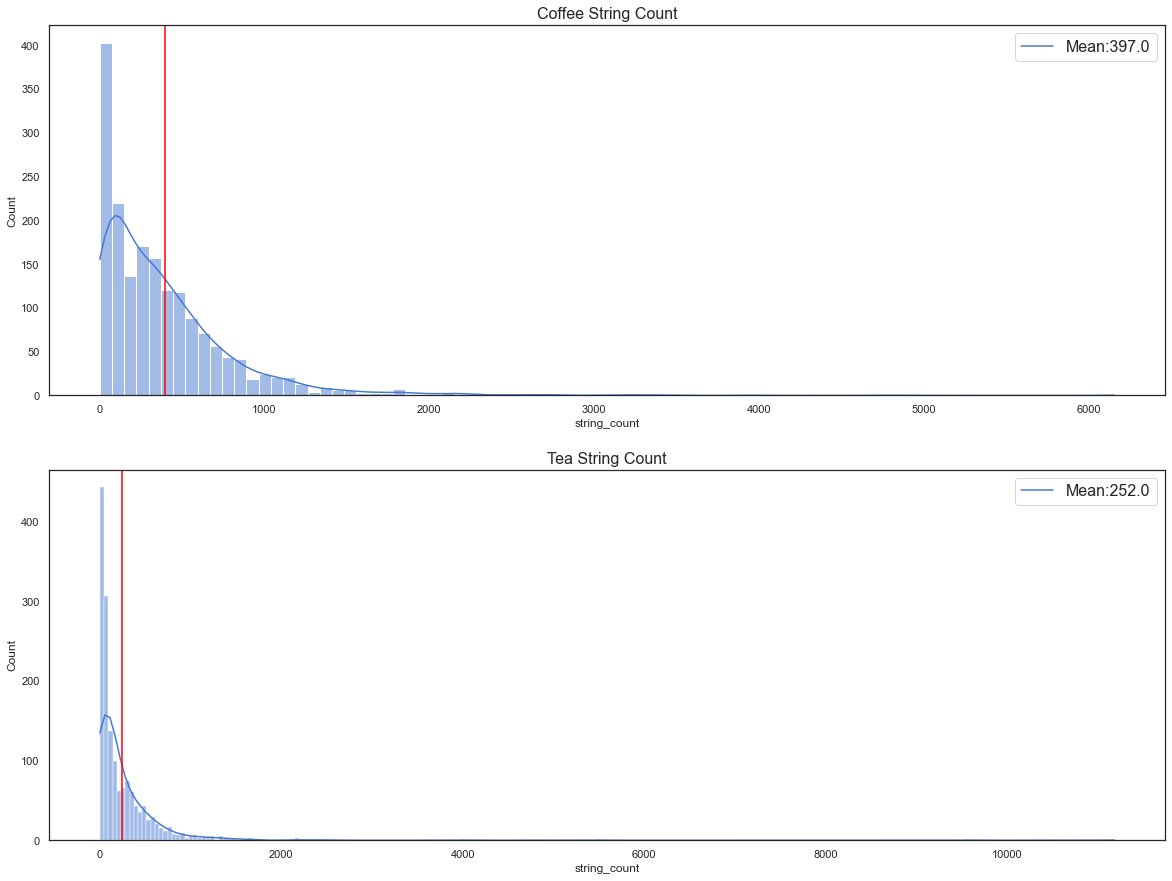

In [22]:
# Distribution of strings
coffee_str = combined_pro[combined_pro['tv']==0]['string_count']
tea_str = combined_pro[combined_pro['tv']==1]['string_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

# coffee distplot
sns.histplot(coffee_str, ax=ax1, kde=True).axvline(coffee_str.mean(),color='red')
ax1.set_title('Coffee String Count', fontsize=16)
ax1.legend({f'Mean:{round(coffee_str.mean(),0)}':coffee_str.mean()}, fontsize=16)


# tea distplot
sns.histplot(tea_str, ax=ax2, kde=True).axvline(tea_str.mean(), color='red')
ax2.set_title('Tea String Count', fontsize=16)
ax2.legend({f'Mean:{round(tea_str.mean(),0)}':tea_str.mean()}, fontsize=16);
print(tea_str.skew())
print(coffee_str.skew())

The average `string_count` for Coffee and Tea subreddit posts are 397 and 252 respectively and have a distribution that is skewed to the right, suggesting that majority of both posts tend to be succinct in nature.

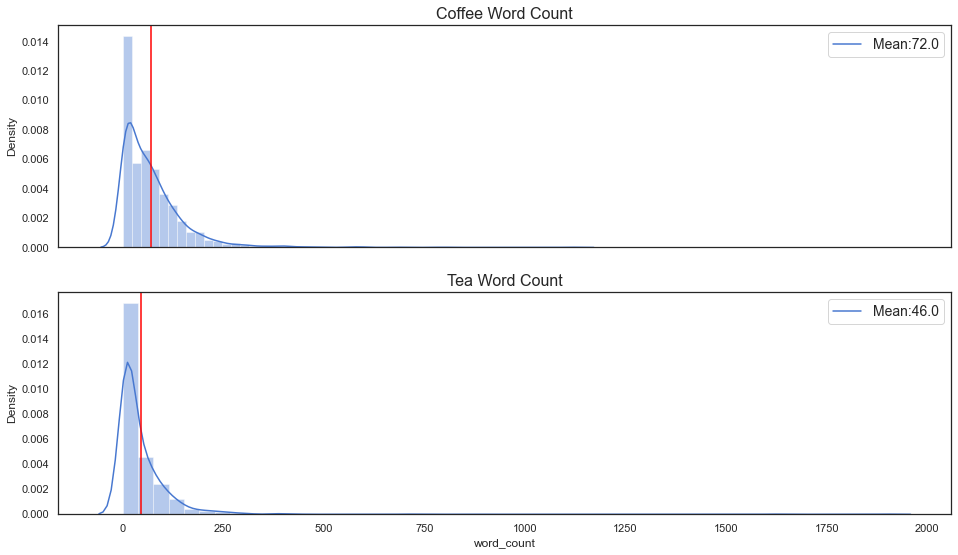

In [23]:
# Distribution of words
coffee_word = combined_pro[combined_pro['tv']==0]['word_count']
tea_word = combined_pro[combined_pro['tv']==1]['word_count']

sns.set(style="white", palette="muted", color_codes=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharex=True)

# Coffee distplot
sns.distplot(coffee_word, ax=ax1).axvline(coffee_word.mean(), color='red')
ax1.set_title('Coffee Word Count', fontsize=16)
ax1.legend({f'Mean:{round(coffee_word.mean(),0)}':coffee_word.mean()}, fontsize=14)

# Tea distplot
sns.distplot(tea_word, ax=ax2).axvline(tea_word.mean(), color='red')
ax2.set_title('Tea Word Count', fontsize=16)
ax2.legend({f'Mean:{round(tea_word.mean(),0)}':tea_word.mean()}, fontsize=14);

The average `word_count` for Coffee and Tea subreddit posts are 72 and 46 respectively, and also have a distribution that is skewed to the right. On average, Coffee subreddit posts are longer than Tea subreddit posts.

# Pre-processing

Going back to the 'text' column of our combined_pro dataset, we can perform some pre-processing on the text data which will allow us to perform more interesting analysis, modelling and visualizations.

When dealing with text data, there are common pre-processing steps:

- Tokenizing
- Regular Expressions
- Lemmatizing/Stemming
- Cleaning (Removing stopwords and HTTP etc.)


When we "tokenize" data, we take it and split it up into distinct chunks based on some pattern.
Regular Expressions, or RegEx, is a helpful tool for detecting patterns in text.
Lemmatizing and stemming are two forms of shortening words so that we can combine similar forms of the same word. When we "lemmatize" data, we take words and attempt to return their lemma, or the base/dictionary form of a word. When we "stem" data, we take words and attempt to return a base form of the word. It tends to be cruder than using lemmatization. For this project, we will opt to use lemmatization over stemming to ensure the words are reduced to their common form as closely as possible.

Stopwords are very common words that are often removed because they can amount to unnecessary information and removing them can dramatically speed things up.

### Text processing

In [24]:
def text_processing(raw_text):

    leakage_words = ['tea','coffee','im','like','ive','try','water','taste','drink','know','want','cup','taste','look',
                     'question','use','dont','make','help','good','thank']

    # Step 1: Remove HTML
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Step 2: Tokenizing - Remove punctuation and convert all text to lowercase
    tokenizer = RegexpTokenizer(r'\w+')
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # Convert all text to lowercase
    words = letters_only.lower().split()
    
    # Step 3: Remove stopwords and leakage words
    words = [word for word in words if word not in stopwords.words('english')+leakage_words]
    
    # Step 4: Stem or lemmatize each word of the text,
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    #stemmer = PorterStemmer()
    #words = [stemmer.stem(word) for word in words]
    
    # Step 5: Remove any additional stopwords and leakage words that might not have been removed in Step 3
    words = [word for word in words if word not in stopwords.words('english') + leakage_words]
    
    # Return the final string
    return ' '.join(words)

In [25]:
cleaned_text = combined_pro['text'].apply(text_processing)
cleaned_df = combined_pro.copy()
cleaned_df['text'] = cleaned_text
cleaned_df['original_text'] = combined_pro['text']
cleaned_df.head(10)

,text,tv,string_count,word_count,original_text
0,joe app reward buying,0,36,7,Joe app - rewards for buying coffee
1,saeco incanto carafe ran milk whole thing fren...,0,327,64,"I have a Saeco Incanto Carafe, and ran out of ..."
2,office job provide mean getting buying cafeter...,0,409,71,My office job doesn't provide any means of get...
3,brewing espresso morning,0,28,4,Brewing espresso in morning
4,love dead inside caffeinated shirt follow link...,0,75,14,I love my Dead Inside But Caffeinated Shirt! ...
5,brewing french press grindin g bean known ml y...,0,383,76,Im brewing with a french press. So im grindin ...
6,double espresso much,0,29,5,Is double espresso too much?
7,curious planning trying cold brew purchased qu...,0,435,85,"Was just curious, I was planning on trying to ..."
8,residue tank sits coming clean delonghi ecp,0,117,21,Coffee residue where water tank sits. Where i...
9,new toy adjustment ring turn way past nine goi...,0,496,87,My new toy’s adjustment ring turns way past ni...


In our new cleaned_df, we have created a new column <b>'text'</b> which comprises our processed text after performing tokenization, lemmatization, as well as removing stopwords and leakage words.

### Train test split

Next, we can perform a train test split on our cleaned_df to split the data into train and test datasets for our modelling process, as well as to determine our baseline score.

In [26]:
# Saving this cleaned_df into a csv_file
cleaned_df.to_csv('datasets/cleaned_data.csv', index = False)

In [27]:
# Assigning the features (X) and target variable (y)
X = cleaned_df['text']
y = cleaned_df['tv']

In [28]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle = True, stratify=y)

In [29]:
# Number of rows in the train set
X_train.shape

(2517,)

In [30]:
# Number of rows in the test set
X_test.shape

(840,)

In [31]:
# Proportion of Class 1 and 0
y.value_counts(normalize=True)

0    0.533214
1    0.466786
Name: tv, dtype: float64

The train data has the same proportion of coffee and tea posts as the original dataset because we have used stratification in our train test split. With the baseline accuracy being the same at 53.32%, we are confident in getting a Coffee subreddit post 53.32% of the time.

In [32]:
# Proportion of Class 1 and 0 in train dataset
y_train.value_counts(normalize=True)

0    0.533174
1    0.466826
Name: tv, dtype: float64

In [33]:
# Overview of X_train
X_train

2088    working recipe hard iced first attempt came ta...
1867    collection first year hobby live lebanon small...
2881                                            essential
3311    golden sail black lichee favorite since child ...
3289    blue red white yellow lotus lavender rose peta...
                              ...                        
1074    feeling tightness chest drinking half ok need ...
2291         first time trying harney son looking forward
1239                      jimmy butler travel la marzocco
413     originally told either aeropress french press ...
839                                                   yes
Name: text, Length: 2517, dtype: object

In [34]:
# Overview of y_train
y_train

2088    1
1867    1
2881    1
3311    1
3289    1
       ..
1074    0
2291    1
1239    0
413     0
839     0
Name: tv, Length: 2517, dtype: int64

### Most Common Words for Coffee subreddit

In [35]:
coffee_text = cleaned_df[cleaned_df['tv'] == 0]['text']
coffee_text.shape

(1790,)

In [36]:
coffee_train = pd.merge(X_train, coffee_text, how='inner', on=['text'])
print(coffee_train.shape)
coffee_train

(1421, 1)


,text
0,whenever go shop near pour always acidic fruit...
1,tend grind week two worth bean put ground vacu...
2,found bag ground year best brew bin
3,looking brewer ml would replace aeropress scal...
4,add evangiely snap give something
...,...
1416,machine tank smelled bad cleaned vinegar smell...
1417,tl dr poor friend million dollar coffe product...
1418,feeling tightness chest drinking half ok need ...
1419,jimmy butler travel la marzocco


In [37]:
# use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(min_df = 2, stop_words='english')

# Fit our vectorizer into Coffee posts in our X_train
cvec.fit(coffee_train['text'])

# Total number of features (words) in Coffee posts in X_train
print('Number of features without stop words: {}'.format(len(cvec.get_feature_names())))

Number of features without stop words: 2809


In [38]:
coffee_words = pd.DataFrame(cvec.transform(coffee_train['text']).todense(),
                       columns=cvec.get_feature_names())

In [39]:
coffee_words.head()

,ability,able,absolute,absolutely,acaia,acceptable,access,accessible,accident,accidentally,...,yes,yesterday,yield,younger,youtube,yr,zassenhaus,zealand,zero,zpresso
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#top 100 words used in coffee subreddit submission posts
coffee_top = coffee_words.sum(axis = 0).sort_values(ascending = False).head(100)
coffee_top

machine     424
grinder     411
espresso    404
bean        364
brew        324
           ... 
second       63
advice       63
dark         61
little       61
light        61
Length: 100, dtype: int64

In [41]:
# Name of Top 100 most frequent Features/Columns
coffee_pd = pd.DataFrame(data=coffee_top)
coffee_pd.index

Index(['machine', 'grinder', 'espresso', 'bean', 'brew', 'grind', 'time',
       'looking', 'using', 'really', 'need', 'filter', 'day', 'best', 'new',
       'cold', 'milk', 'roast', 'press', 'way', 'year', 'ground', 'pour',
       'french', 'tried', 'used', 'better', 'thing', 'got', 'pot', 'buy',
       'thanks', 'think', 'home', 'love', 'work', 'aeropress', 'different',
       'fine', 'burr', 'drinking', 'recommendation', 'method', 'caffeine',
       'experience', 'lot', 'recently', 'brewing', 'hi', 'setting', 'moka',
       'size', 'suggestion', 'shop', 'morning', 'getting', 'bought', 'making',
       'trying', 'drip', 'maker', 'people', 'come', 'going', 'long', 'pretty',
       'say', 'feel', 'roaster', 'right', 'le', 'thought', 'week', 'bit',
       'hand', 'latte', 'sure', 'great', 'flavor', 'started', 'start', 'black',
       'bag', 'starbucks', 'ratio', 'wondering', 'extraction', 'issue', 'shot',
       'usually', 'pro', 'problem', 'brand', 'iced', 'kettle', 'second',
       'a

In [42]:
# Filtering out the top 10 words/columns
coffee_top = coffee_words[coffee_pd.index]
coffee_top.head()

,machine,grinder,espresso,bean,brew,grind,time,looking,using,really,...,pro,problem,brand,iced,kettle,second,advice,dark,little,light
0,0,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Word Cloud of Most Common Words in Coffee subreddit

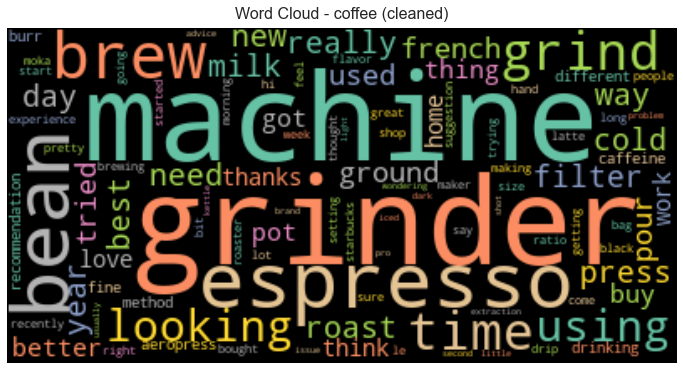

In [43]:
# Generate Word Cloud
wordcloud_coffee = WordCloud(background_color="black", colormap='Set2').generate(' '.join(coffee_top))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_coffee, interpolation='bilinear')
plt.title('Word Cloud - coffee (cleaned)', fontsize=16, y=1.01)
plt.axis("off");

In [44]:
word_counts = coffee_words.sum(axis=0)
print("Top 10 words used in coffee subreddit")
word_counts.sort_values(ascending = False).head(20)

Top 10 words used in coffee subreddit


machine     424
grinder     411
espresso    404
bean        364
brew        324
grind       281
time        277
looking     227
using       197
really      196
need        168
filter      166
day         157
best        156
new         155
cold        152
milk        150
roast       150
press       149
way         148
dtype: int64

<AxesSubplot:>

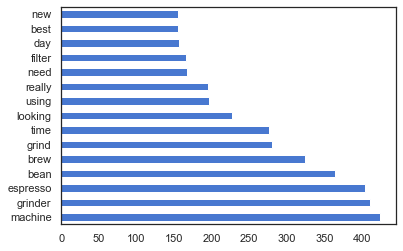

In [46]:
coffee_words.sum().sort_values(ascending=False).head(15).plot(kind='barh')

In [47]:
# use the stop_words argument to remove words like "and, the, a", min_df = 2 to ignore words that appear less than twice
# construct a bigram
cvec = CountVectorizer(ngram_range=(2,2), min_df = 2, stop_words='english')

# Fit our vectorizer into Coffee posts in our X_train
cvec.fit(coffee_train['text'])

# Total number of features (words) in Coffee posts in X_train
print('Number of features without stop words in bigram: {}'.format(len(cvec.get_feature_names())))

Number of features without stop words in bigram: 2590


In [48]:
coffee_words_bigram = pd.DataFrame(cvec.transform(coffee_train['text']).todense(),
                       columns=cvec.get_feature_names())
coffee_words_bigram.sample(20)

,able espresso,able function,able great,able grind,acceptable brew,acidic acceptable,acidic fruity,acidic guessing,acidic sour,acidity method,...,youtube channel,youtube day,youtube video,yr old,zealand budget,zero filter,zpresso grinder,zpresso jx,zpresso plus,zpresso pro
339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
coffee_bigram_top = coffee_words_bigram.sum(axis = 0).sort_values(ascending = False).head(100)
coffee_bigram_top

french press        127
cold brew           120
espresso machine    106
moka pot             70
grind size           45
                   ... 
tasting note          8
filter machine        8
left right            8
flat white            7
grinder pro           7
Length: 100, dtype: int64

In [50]:
coffee_bigram_top.head()

french press        127
cold brew           120
espresso machine    106
moka pot             70
grind size           45
dtype: int64

<AxesSubplot:>

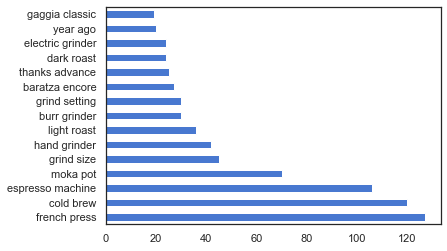

In [51]:
coffee_words_bigram.sum().sort_values(ascending=False).head(15).plot(kind='barh')

### Most Common Words for Tea subreddit

In [52]:
tea_text = cleaned_df[cleaned_df['tv'] == 1]['text']
tea_text.shape

(1567,)

In [53]:
# Number of Tea Posts in the X_train data set
tea_train = pd.merge(X_train, tea_text, how='inner', on=['text'])
print(tea_train.shape)
tea_train

(1261, 1)


,text
0,working recipe hard iced first attempt came ta...
1,collection first year hobby live lebanon small...
2,essential
3,golden sail black lichee favorite since child ...
4,blue red white yellow lotus lavender rose peta...
...,...
1256,beautiful garden spring tasted year spring
1257,passed great grandmother teapot anyone helpful...
1258,earl grey creme brulee
1259,hi r need recommendation oolong head favorite ...


In [54]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(min_df = 2, stop_words='english')

# Fit our vectorizer into our tea posts in our dataframe
cvec.fit(tea_train['text'])

# Total number of features (words) in Tea Subreddit posts in our X_train
print('Number of features without stop words: {}'.format(len(cvec.get_feature_names())))

Number of features without stop words: 2065


In [55]:
# Transforming using our fitted cvec and converting the result to a DataFrame
tea_words = pd.DataFrame(cvec.transform(tea_train['text']).todense(),
                       columns=cvec.get_feature_names())

In [56]:
# Finding the top 100 words that frequently appeared in Tea subreddit
tea_top = tea_words.sum(axis = 0).sort_values(ascending = False).head(100)
tea_top

leaf         213
green        175
black        168
time         154
oolong       125
            ... 
brewed        35
breakfast     35
pretty        35
honey         34
fu            34
Length: 100, dtype: int64

In [57]:
# Name of Top 100 most frequent Features/Columns
tea_pd = pd.DataFrame(data=tea_top)
tea_pd.index

Index(['leaf', 'green', 'black', 'time', 'oolong', 'new', 'really', 'loose',
       'recommendation', 'flavor', 'looking', 'drinking', 'best', 'day', 'got',
       'matcha', 'teapot', 'love', 'tried', 'white', 'bag', 'brew', 'thanks',
       'milk', 'way', 'kettle', 'set', 'buy', 'pot', 'brewing', 'little',
       'favorite', 'pu', 'steep', 'caffeine', 'brand', 'wondering', 'year',
       'lot', 'different', 'er', 'need', 'ml', 'trying', 'blend', 'recently',
       'sugar', 'think', 'quality', 'hot', 'iced', 'place', 'people', 'using',
       'say', 'thing', 'bought', 'bit', 'hi', 'kind', 'shop', 'chinese',
       'sure', 'feel', 'store', 'making', 'order', 'work', 'morning', 'start',
       'chai', 'idea', 'great', 'thought', 'better', 'long', 'let', 'sencha',
       'today', 'type', 'cold', 'suggestion', 'gaiwan', 'nice', 'going',
       'style', 'getting', 'japanese', 'online', 'herbal', 'china', 'come',
       'maybe', 'stuff', 'gong', 'brewed', 'breakfast', 'pretty', 'honey',
    

In [58]:
tea_top = tea_words[tea_pd.index]
tea_top.head()

,leaf,green,black,time,oolong,new,really,loose,recommendation,flavor,...,china,come,maybe,stuff,gong,brewed,breakfast,pretty,honey,fu
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Word Cloud of Most Common Words in Tea subreddit

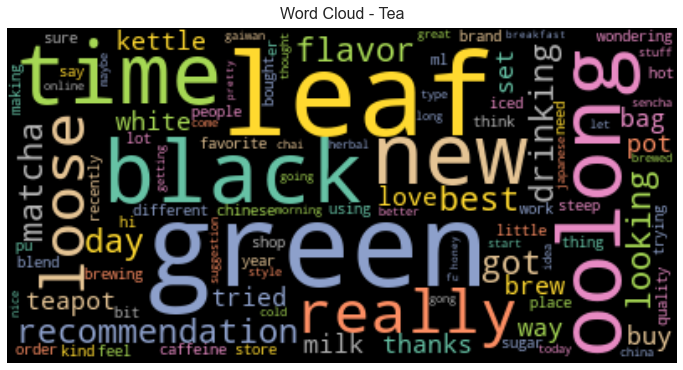

In [59]:
tea_ds = WordCloud(background_color="black", colormap='Set2').generate(' '.join(tea_top))
plt.figure(figsize = (12,10))
plt.imshow(tea_ds, interpolation='bilinear')
plt.title('Word Cloud - Tea', fontsize=16, y=1.01)
plt.axis("off");

In [60]:
word_counts2 = tea_words.sum(axis=0)
print("Top 20 words used in Tea subreddit")
word_counts2.sort_values(ascending = False).head(20)

Top 20 words used in Tea subreddit


leaf              213
green             175
black             168
time              154
oolong            125
new               120
really            115
loose             108
recommendation    105
flavor            103
looking            97
drinking           97
best               95
day                95
got                94
matcha             93
teapot             93
love               92
tried              91
white              87
dtype: int64

<AxesSubplot:>

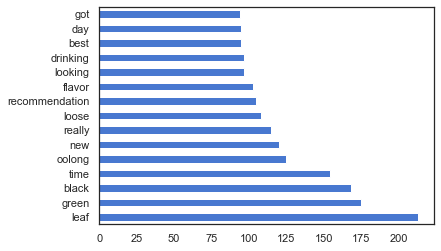

In [61]:
tea_words.sum().sort_values(ascending=False).head(15).plot(kind='barh')

In [62]:
# use the stop_words argument to remove words like "and, the, a", min_df = 2 to ignore words that appear less than twice
# construct a bigram for words use in Tea subreddit
cvec = CountVectorizer(ngram_range=(2,2), min_df = 2, stop_words='english')

# Fit our vectorizer into Coffee posts in our X_train
cvec.fit(tea_train['text'])

# Total number of features (words) in Coffee posts in X_train
print('Number of features without stop words in bigram: {}'.format(len(cvec.get_feature_names())))

Number of features without stop words in bigram: 961


In [63]:
tea_words_bigram = pd.DataFrame(cvec.transform(tea_train['text']).todense(),
                       columns=cvec.get_feature_names())
tea_words_bigram.sample(20)

,able brew,absolute favorite,absolutely delicious,absolutely love,adagio yunnan,add ice,add ingredient,add leaf,add little,add sugar,...,year love,year old,yerba mate,yi wu,yixing pot,yixing teapot,yorkshire gold,yunnan golden,yunnan sourcing,yuuki cha
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
tea_bigram_top = tea_words_bigram.sum(axis = 0).sort_values(ascending = False).head(100)
tea_bigram_top

loose leaf         85
pu er              59
gong fu            31
earl grey          29
harney son         24
                   ..
best experience     4
best loose          4
best place          4
moroccan mint       4
decaf black         4
Length: 100, dtype: int64

<AxesSubplot:>

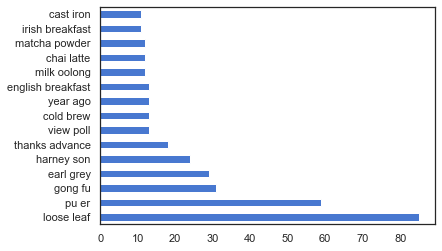

In [65]:
tea_words_bigram.sum().sort_values(ascending=False).head(15).plot(kind='barh')

## Modelling

For our modelling attempts, we will only be considering the 'text' column of our dataset, which has been cleaned and processed, as the only feature. This is because we are trying to train our model based solely on the text content of a subreddit post. Thus, our model should be able to perform the classification based only on the text from the 'title' and 'selftext' columns.

For the purpose of this project, the models we will be using are as follows: `MultinomialNB`, KNeighborsClassifier, RandomForestClassifier, `LogisticRegression` and SupportVectorMachines.

### 1. Naive Bayes - Multinomial NB

The Naive Bayes classification algorithm is a classification modelling technique that relies on Bayes Theorem and assumes that our features are independent of one another. The advantage of making such an assumption is that it makes it easier to calculate the probabilities - however, it would be unrealistic especially in the case of text data as while our classifications may be accurate, our predicted probabilities may produce unsatisfactory results. In particular, we will be using the `MultinomialNB` model in this case.

### CountVectorize Transformer - Multinomial NB

In [66]:
# CountVectorizer

# Setting up a Pipeline with CountVectorizer (Transformer) and MultinomialNB (Estimator)
pipe_1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters
pipe_params_1 = {
    'cvec__max_features': [4000], #[3000, 4000, 5000],
    'cvec__max_df': [0.2], #[0.1, 0.2, 0.3],
    'cvec__min_df': [2], #[1, 2, 3],
    'cvec__ngram_range': [(1,1), (1,2), (2,2)],
    'nb__alpha': np.linspace(0, 1, 5)
}

In [67]:
# Instantiate GridSearchCV
gs1 = GridSearchCV(pipe_1, pipe_params_1, cv=5, verbose=True, n_jobs=-1)

# Fit GridSearch to training data
gs1.fit(X_train, y_train)

# Finding the Best Hyperparameter Values
gs1.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


{'cvec__max_df': 0.2,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.5}

In [68]:
print(gs1.best_score_)

0.8645223894726877


In [69]:
preds = gs1.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

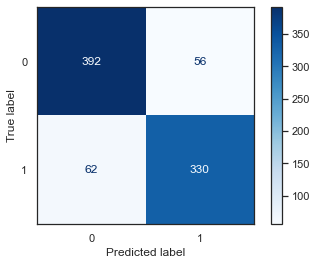

In [70]:
plot_confusion_matrix(gs1, X_test, y_test, cmap='Blues', values_format='d');

In [71]:
# Save confusion matrix values to new variables
nb_cvec_tn = tn
nb_cvec_fp = fp
nb_cvec_fn = fn
nb_cvec_tp = tp

In [72]:
# Save Training and Testing Accuracy in a new variable
nb_cvec = gs1.best_estimator_

### TD-IDF Transformer - Multinomial NB

In [73]:
# TFIDFVectorizer

# Setting up a Pipeline with TFIDFVectorizer (Transformer) and MultinomialNB (Estimator)
pipe_2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters
pipe_params_2 = {
    'tvec__max_features': [8000], #[7000, 8000, 9000],
    'tvec__max_df': [0.4], #[0.4, 0.6, 0.9],
    'tvec__min_df': [2], #[1, 2, 3],
    'tvec__ngram_range': [(1,2)], #[(1,1), (1,2), (2,2)],
    'nb__alpha': np.linspace(0, 1, 5)
}

In [74]:
# Instantiate GridSearchCV
gs2 = GridSearchCV(pipe_2, pipe_params_2, cv=5, verbose=True, n_jobs=-1)

# Fit GridSearch to training data
gs2.fit(X_train, y_train)

# Finding the Best Hyperparameter Values
gs2.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'nb__alpha': 0.25,
 'tvec__max_df': 0.4,
 'tvec__max_features': 8000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [75]:
print(gs2.best_score_)

0.8641295086623119


In [76]:
preds = gs2.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

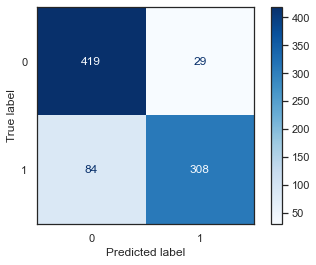

In [77]:
plot_confusion_matrix(gs2, X_test, y_test, cmap='Blues', values_format='d');

In [78]:
# Save confusion matrix values to new variables
nb_tvec_tn = tn
nb_tvec_fp = fp
nb_tvec_fn = fn
nb_tvec_tp = tp

In [79]:
# Save Training and Testing Accuracy in a new variable
nb_tvec = gs2.best_estimator_

### CountVectorize Transformer - Logistic Regression

In [80]:
# CountVectorizer

# Setting up a Pipeline with CountVectorizer (Transformer) and Logistic Regression (Estimator)
pipe_3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear', random_state = 42))
])

# Search over the following values of hyperparameters
pipe_params_3 = {
    'cvec__max_features': [8000], #[6000, 7000, 8000],
    'cvec__max_df': [0.4], #[0.4, 0.6, 0.9],
    'cvec__min_df': [1], #[1, 2, 3],
    'cvec__ngram_range': [(1,1)], #[(1,2), (2,2)],
    'lr__penalty': ['l2'], #['l1', 'l2'],
    'lr__C': [1, 0.5, 0.1]
}

In [81]:
# Instantiate GridSearchCV
gs3 = GridSearchCV(pipe_3, pipe_params_3, cv=5, verbose=True, n_jobs=-1)

# Fit GridSearch to training data
gs3.fit(X_train, y_train)

# Finding the Best Hyperparameter Values
gs3.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


{'cvec__max_df': 0.4,
 'cvec__max_features': 8000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'lr__C': 0.5,
 'lr__penalty': 'l2'}

In [82]:
print(gs3.best_score_)

0.8315622140174824


In [83]:
# Setting up a Pipeline with TF-IDF (Transformer) and Logistic Regression (Estimator)
preds = gs3.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

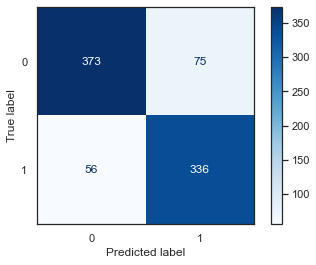

In [84]:
plot_confusion_matrix(gs3, X_test, y_test, cmap='Blues', values_format='d');

In [85]:
# Save confusion matrix values to new variables
lr_cvec_tn = tn
lr_cvec_fp = fp
lr_cvec_fn = fn
lr_cvec_tp = tp

In [86]:
# Save Training and Testing Accuracy in a new variable
lr_cvec = gs3.best_estimator_

### TD-IDF Transformer - Logistic Regression

In [87]:
# TFIDFVectorizer

# Setting up a Pipeline with TF-IDF (Transformer) and Logistic Regression (Estimator)
pipe_4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear', random_state = 42))
])

# Search over the following values of hyperparameters
pipe_params_4 = {
    'tvec__max_features': [4000], #[4000, 5000, 6000]
    'tvec__max_df': [0.1], #[0.1, 0.2, 0.4],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,2), (2,2)],
    'lr__penalty': ['l2'], #['l1', 'l2'],
    'lr__C': [1, 0.5, 0.1]
}

In [88]:
# Instantiate GridSearchCV
gs4 = GridSearchCV(pipe_4, pipe_params_4, cv=5, verbose=True, n_jobs=-1)

# Fit GridSearch to training data
gs4.fit(X_train, y_train)

# Finding the Best Hyperparameter Values
gs4.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.1,
 'tvec__max_features': 4000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [89]:
print(gs4.best_score_)

0.8609556944049984


In [90]:
# Setting up a Pipeline with TF-IDF (Transformer) and Logistic Regression (Estimator)
preds = gs4.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

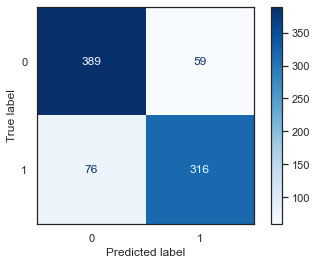

In [91]:
plot_confusion_matrix(gs4, X_test, y_test, cmap='Blues', values_format='d');

In [92]:
# Save confusion matrix values to new variables
lr_tvec_tn = tn
lr_tvec_fp = fp
lr_tvec_fn = fn
lr_tvec_tp = tp

In [93]:
# Save Training and Testing Accuracy in a new variable
lr_tvec = gs4.best_estimator_

### Summary of Results

In [94]:
models = [nb_cvec, nb_tvec, lr_cvec, lr_tvec] #the gs.best_estimator_ of the models
name = ['Naive-Bayes', 'Naive-Bayes', 'Logistics Regression', 'Logistic Regression', 'Delta']
vec = ['Count Vectorizer', 'TFIDF Vectorizer', 'Count Vectorizer', 'TFIDF Vectorizer', 'Delta']
TN = [nb_cvec_tn, nb_tvec_tn, lr_cvec_tn, lr_tvec_tn]
FP = [nb_cvec_fp, nb_tvec_fp, lr_cvec_fp, lr_tvec_fp]
FN = [nb_cvec_fn, nb_tvec_fn, lr_cvec_fn, lr_tvec_fn]
TP = [nb_cvec_tp, nb_tvec_tp, lr_cvec_tp, lr_tvec_tp]
Delta = []
final_list = []

for i, model in enumerate(models):
    final_dict = dict()
    final_dict['Model'] = name[i]
    final_dict['Vectorizer'] = vec[i]
    final_dict['Training Score'] = round(model.score(X_train, y_train), 3)
    final_dict['Testing Score'] = round(model.score(X_test, y_test), 3)
    final_dict['TN'] = TN[i]
    final_dict['FN'] = FN[i]
    final_dict['TP'] = TP[i]
    final_dict['FP'] = FP[i]
    final_dict['Delta'] = final_dict['Training Score'] - final_dict['Testing Score']

    final_list.append(final_dict)

final_list = pd.DataFrame(final_list)

In [95]:
final_list

,Model,Vectorizer,Training Score,Testing Score,TN,FN,TP,FP,Delta
0,Naive-Bayes,Count Vectorizer,0.926,0.860,392,62,330,56,0.066
1,Naive-Bayes,TFIDF Vectorizer,0.963,0.865,419,84,308,29,0.098
2,Logistics Regression,Count Vectorizer,0.972,0.844,373,56,336,75,0.128
3,Logistic Regression,TFIDF Vectorizer,0.956,0.839,389,76,316,59,0.117


After collating our results from our 10 models in the table above, I have decided to pick the first model using <b>CountVectorizer Transformer</b> and <b>MultinomialNB classifier</b> as my best model. Although it had a slightly lower test score than the model using <b>TFIDF Vectorizer Transformer</b> and <b>MultinomialNB classifier</b>, the delta between scores was lower at `0.066` as compared to `0.098` for the latter. Moreover, the test score was 2nd in terms of test score and was only 0.05 points away from the model with the top test score.

In [96]:
# Create a dataframe called pred_df that contains:
# 1) The list of true values in our test set
# 2) The list of predicted probabilities based on the chosen model

pred_proba = [i[1] for i in gs1.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

pred_df.head()

,true_values,pred_probs
161,0,6.095526e-30
726,0,9.614101e-05
37,0,1.550749e-35
3113,1,7.925771e-01
2315,1,1.068082e-01


### Evaluation

The next step would be to evaluate our chosen model -- for this we have chosen the ROC-AUC curve to assess the performance of the model at distinguishing between the positive and negative classes.

To provide a brief description, the Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.


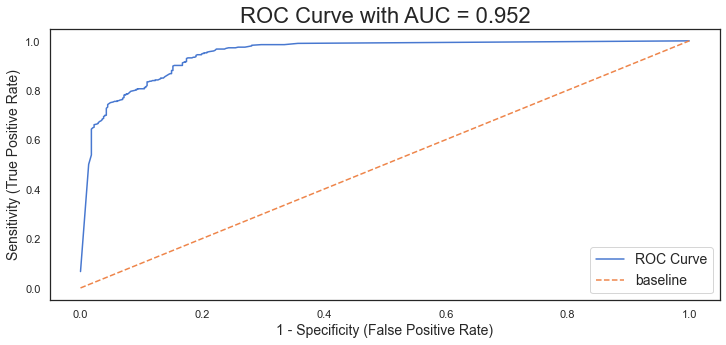

In [99]:
# Creating the area under ROC
plt.figure(figsize = (12,5))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def tprate(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def fprate(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [tprate(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [fprate(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# plot baseline.
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=14)
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=14)

# create a legend for ROC curve and baseline.
plt.legend(fontsize=14);

The results of our model based on the ROC-AUC curve are impressive with a score of <b>0.952</b>, signifying that our chosen model is able to mostly distinguish between the positive and negative classes.

### Feature Importance

Next, we want to identify which words are the best in determining whether a post belongs to either the Coffee or Tea subreddit based on our model. To do this, we will calculate the coefficient strengths of the features.

In [100]:
#Set variables to access the model steps by name
gs_model1 = nb_cvec

transformer1 = gs_model1.named_steps['cvec']
estimator1 = gs_model1.named_steps['nb']

In [101]:
#Create a new dataframe to store the coefficients of the features
tea_coeff = pd.DataFrame()
tea_coeff['feature'] = transformer1.get_feature_names()
tea_coeff['log_prob_diff'] = estimator1.feature_log_prob_[1,:] - estimator1.feature_log_prob_[0,:]

In [102]:
#show the top 10 features with the strongest coefficients for Tea
tea_coeff = tea_coeff.sort_values(by=['log_prob_diff'], ascending=False).head(10)

In [103]:
coffee_coeff = pd.DataFrame()
coffee_coeff['feature'] = transformer1.get_feature_names()
coffee_coeff['log_prob_diff'] = estimator1.feature_log_prob_[0,:] - estimator1.feature_log_prob_[1,:]

In [104]:
#show the top 10 features with the strongest coefficients for Coffee
coffee_coeff = coffee_coeff.sort_values(by=['log_prob_diff'], ascending=False).head(10)

Text(0, 0.5, 'Words')

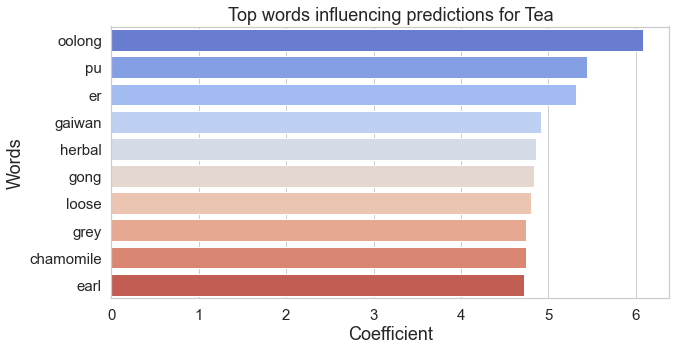

In [105]:
#visualize the top 10 words influencing predictions for Tea
sns.set(style='whitegrid',rc={"figure.figsize": (10, 5)})
sns.barplot(y='feature',x='log_prob_diff', data=tea_coeff.head(10), palette='coolwarm')
plt.title('Top words influencing predictions for Tea', fontsize=18)
plt.tick_params(labelsize=15)
plt.xlabel('Coefficient', fontsize=18)
plt.ylabel('Words', fontsize=18)

Text(0, 0.5, 'Words')

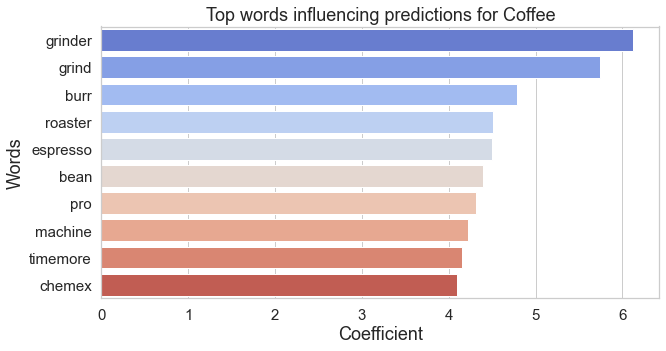

In [106]:
#visualize the top 10 words influencing predictions for Coffee
sns.set(style='whitegrid',rc={"figure.figsize": (10, 5)})
sns.barplot(y='feature',x='log_prob_diff', data=coffee_coeff.head(10), palette='coolwarm')
plt.title('Top words influencing predictions for Coffee', fontsize=18)
plt.tick_params(labelsize=15)
plt.xlabel('Coefficient', fontsize=18)
plt.ylabel('Words', fontsize=18)

It is observed that words such as `oolong`, `pu` and `er` are important features to the Tea subreddit, whereas interestingly, words such as `grinder`, `grind` and `burr` are important features to the Coffee subreddit.

### Conclusion

After running our data through 4 model combinations, I have chosen the `MultinomialNB - CvecVectorizer model` combination with a score of 86.0% in predicting which subreddit a post came from (Coffee or Tea). Although the model came in second in test score, the basis for choosing this model was due to the lower delta between the Train and Test score (0.066) as compared to the higher delta between the model with the highest test score (0.098). Moreover, this model also had a high ROC-AUC score of <b>95.2%</b> - meaning the model is able to mostly distinguish between the positive and negative classes.

Using GridSearchCV, the best hyperparameters for this particular model is:
* 'cvec__max_df': 0.6,
* 'cvec__max_features': 2000,
* 'cvec__min_df': 2,
* 'cvec__ngram_range': (1, 1),
* 'nb__alpha': 0.25

From our Data Visualizations, we have identified Coffee Subreddit to have key words such as `grinder`, `grind`, `burr`, `roaster`. On the other hand, the Tea subreddit tends to have key words like `oolong`, `pu`, `er`, and `gaiwan`. Given enough time, perhaps a further study can be conducted to understand how and why words such as `grind` and `burr` are some of the top keywords for the Coffee subreddit.

### Recommendations
When it comes to modelling, introducing more data features may improve our modelling accuracy scores. One other possible area of focus can be the comments section of subreddit threads. 

Since Reddit also has numerous submissions where the selftext is an image (imgur.com), if these can be used in Machine Learning for image classification, it may also help to improve our accuracy scores.